# Ataques cibernéticos - Projeto Big Data 2024/2025

Grupo:
- Barbara Xavier Sobral - 2024104488
- Maria Margarido Ribeiro - 202410412
- Mariana Sofia Mendes Prata de Almeida - 2024102807

In [1]:
pip install pyspark findspark

In [2]:
# Importar bibliotecas

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, mean, stddev, min, max, lit, expr
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

### 1. Criar uma sessão Spark

In [3]:
# Criar a sessão do Spark
spark = SparkSession.builder \
    .appName("AtaquesCibernéticos_BigDataProject") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

### 2. Ler o dataset com Spark

In [4]:
# Caminhos dos ficheiros CSV
caminho_features = "NUSW-NB15_features.csv"
caminhos_dados = ["UNSW-NB15_1.csv", "UNSW-NB15_2.csv", "UNSW-NB15_3.csv", "UNSW-NB15_4.csv"]

# Ler o ficheiro de features e extrair apenas a coluna 'Name'
features_df = spark.read.csv(caminho_features, header=True, inferSchema=True)
colunas = features_df.select("Name").rdd.flatMap(lambda x: x).collect()  # Converte para lista

# Ler os ficheiros de dados e aplicar os nomes das colunas
dfs = [spark.read.csv(f, header=False, inferSchema=True).toDF(*colunas) for f in caminhos_dados]

# Juntar todos os DataFrames
df_final = dfs[0]
for df in dfs[1:]:
    df_final = df_final.union(df)

# Mostrar as primeiras linhas do DataFrame final
df_final.show(10)

+-----------+-----+-------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+-----------+-----------+-----+-----+----+----+-----+-----+-------+-------+-----------+-----------+---------+---------+----------+----------+-------+--------+------+------+------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+----------+-----+
|      srcip|sport|        dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|      Sload|      Dload|Spkts|Dpkts|swin|dwin|stcpb|dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|     Sjit|     Djit|     Stime|     Ltime|Sintpkt| Dintpkt|tcprtt|synack|ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|attack_cat|Label|
+-----------+-----+-------------+------+-----+-----+--------+------+--

Uma vez que o dataset estava dividido em 4 ficheiros, extraimos os nomes das colunas do ficheiro "NUSH-NB15_Features.csv" e aplicámos à junção dos 4 ficheiros que nao possuiam o nome das variáveis. Deste modo, cirámos um novo Dataset que corresponde à junção de todos, permitindo processar os dados mais facilmente.


### 3. Filtragem dos Dados

In [5]:
# Remoção das linhas que representam conexões normais ("Não Ataque")
df_ataques = df_final.filter(df_final["Label"] == 1)  # Mantém apenas registos de ataques
df_ataques.show(10)
df_ataques.printSchema()

# Verifica a contagem de registos antes e depois do filtro
print("Total de registros no dataset original:", df_final.count())
print("Total de registros de ataques:", df_ataques.count())

+------------+-----+--------------+------+-----+-----+--------+------+------+----+----+-----+-----+-------+------------+-----------+-----+-----+----+----+----------+----------+-------+-------+-----------+-----------+-----------+-----------+----------+----------+----------+----------+--------+--------+--------+---------------+------------+----------------+------------+----------+----------+----------+----------+-----------+----------------+----------------+--------------+--------------+-----+
|       srcip|sport|         dstip|dsport|proto|state|     dur|sbytes|dbytes|sttl|dttl|sloss|dloss|service|       Sload|      Dload|Spkts|Dpkts|swin|dwin|     stcpb|     dtcpb|smeansz|dmeansz|trans_depth|res_bdy_len|       Sjit|       Djit|     Stime|     Ltime|   Sintpkt|   Dintpkt|  tcprtt|  synack|  ackdat|is_sm_ips_ports|ct_state_ttl|ct_flw_http_mthd|is_ftp_login|ct_ftp_cmd|ct_srv_src|ct_srv_dst|ct_dst_ltm|ct_src_ ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|    attack_cat|Label|
+-----

Uma vez que o objetivo do projeto é prever a quantidade de dados transferidos durante ataques cibernéticos, foi necessário remover os registos onde não ocorreram ataques. Para tal, foram filtrados os dados de forma a manter apenas os registos classificados como ataques, ou seja, aqueles em que a coluna label tem o valor 1. Esta operação permitiu reduzir o tamanho do dataset, tornando o processamento mais eficiente, além de melhorar a precisão do modelo, dado que o mesmo passa a focar-se exclusivamente no tráfego malicioso.



### 4. Verificar em que colunas existe "-" e valores ausentes

In [6]:
# Função para contar valores '-' em cada coluna
def count_dash_values(dataframe):
    dash_counts = {}
    for column_name in dataframe.columns:
        dash_count = dataframe.filter(col(column_name) == "-").count()
        if dash_count > 0:
            dash_counts[column_name] = dash_count
    return dash_counts

# Contar valores ausentes (null) em cada coluna
null_counts = []
for column_name in df_ataques.columns:
    null_count = df_ataques.filter(col(column_name).isNull()).count()
    if null_count > 0:
        null_counts.append((column_name, null_count))

# Contar valores "-" e valores ausentes
dash_counts = count_dash_values(df_ataques)

print("\nColunas com valores '-':")
for column, count in dash_counts.items():
    print(f"{column}: {count}")

print("\nColunas com valores ausentes (null):")
for column, count in null_counts:
    print(f"{column}: {count}")


Colunas com valores '-':
service: 44909

Colunas com valores ausentes (null):
ct_flw_http_mthd: 163445
is_ftp_login: 170582


### 5. Tratar valores "-" e valores ausentes

In [7]:
# Primeiro, identificamos todas as colunas string que podem conter "-"
string_columns = [field.name for field in df_ataques.schema.fields if isinstance(field.dataType, StringType)]

# Substituir "-" por "ANOTHER" nas colunas de texto
for column in string_columns:
    df_ataques = df_ataques.withColumn(column, when(col(column) == "-", "ANOTHER").otherwise(col(column)))

# Tratar valores ausentes (null) em colunas numéricas com a média
numeric_columns = [field.name for field in df_ataques.schema.fields
                   if isinstance(field.dataType, (IntegerType, DoubleType, LongType))]

# Calcular as médias para cada coluna numérica
for column in numeric_columns:
    # Calculamos a média ignorando valores nulos
    mean_value = df_ataques.select(mean(col(column))).collect()[0][0]

    # Se a média for None (todos os valores são nulos), usamos 0
    if mean_value is None:
        mean_value = 0

    # Substituímos valores nulos pela média
    df_ataques = df_ataques.withColumn(column, when(col(column).isNull(), mean_value).otherwise(col(column)))

print("\nTratamento de valores ausentes e '-' concluído!")


Tratamento de valores ausentes e '-' concluído!


In [8]:
# Verificação após tratamento para confirmar que não existem mais valores "-" ou valores ausentes
print("\nVerificando se ainda existem valores '-' após tratamento:")

# Verificar novamente valores '-' em cada coluna
dash_counts_after = count_dash_values(df_ataques)

if not dash_counts_after:
    print("Não foram encontrados mais valores '-' em nenhuma coluna. Tratamento bem-sucedido!")
else:
    print("Atenção! Ainda existem valores '-' nas seguintes colunas:")
    for column, count in dash_counts_after.items():
        print(f"{column}: {count}")

# Verificar se ainda existem valores ausentes
null_counts_after = []
for column_name in df_ataques.columns:
    null_count = df_ataques.filter(col(column_name).isNull()).count()
    if null_count > 0:
        null_counts_after.append((column_name, null_count))

print("\nVerificando se ainda existem valores ausentes após tratamento:")
if not null_counts_after:
    print("Não foram encontrados mais valores ausentes em nenhuma coluna. Tratamento bem-sucedido!")
else:
    print("Atenção! Ainda existem valores ausentes nas seguintes colunas:")
    for column, count in null_counts_after:
        print(f"{column}: {count}")


Verificando se ainda existem valores '-' após tratamento:
Não foram encontrados mais valores '-' em nenhuma coluna. Tratamento bem-sucedido!

Verificando se ainda existem valores ausentes após tratamento:
Não foram encontrados mais valores ausentes em nenhuma coluna. Tratamento bem-sucedido!


Verificou-se que os valores "-" estavam presentes apenas na variável categórica service. A variável service descreve os serviços de rede mais comuns, como HTTP, FTP, SMTP, SSH, DNS, FTP-data e IRC. No entanto, quando um serviço não pertence a este conjunto mais utilizado, é representado pelo símbolo "-", indicando um serviço menos frequente ou não identificado. Para garantir a consistência dos dados os valores "-" foram substituídos por "another", representando serviços que não se enquadram ou não foram identificados.
Além disso, foram analisadas as colunas numéricas para verificar a existência de valores em falta. Nestes casos, os valores ausentes foram preenchidos utilizando a média da respetiva coluna, evitando a perda de informação e garantindo uma distribuição equilibrada dos dados.


### 6. Normalização das Características Numéricas

In [9]:
# Criar um assembler para todas as colunas numéricas (exceto a variável alvo dbytes)
numeric_features = [col for col in numeric_columns if col != "dbytes" and col != "Label"]

# Criar o VectorAssembler
assembler = VectorAssembler(inputCols=numeric_features, outputCol="numericFeatures")

# Aplicar o assembler
df_assembled = assembler.transform(df_ataques)

# Normalização com StandardScaler
scaler = StandardScaler(inputCol="numericFeatures", outputCol="scaledNumericFeatures",
                        withStd=True, withMean=True)

# Fit do scaler
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

print("\nNormalização das características numéricas concluída!")


Normalização das características numéricas concluída!


A normalização das características numéricas permitiu que todas as variáveis tenham a mesma escala. Para esse efeito, foi utilizada a técnica de normalização StandardScaler e VectorAssembler, que ajusta os dados para que tenham média = 0 e desvio padrão = 1. Este método foi aplicado às variáveis dur, Spkts, Dpkts, sloss e dloss, permitindo que todas as variáveis numéricas tivessem uma contribuição equilibrada no modelo de machine learning

### 7. Transformação de Variáveis Categóricas

In [10]:
# Identificar colunas categóricas
categorical_columns = [col for col in string_columns if col != "attack_cat"]

# Pipeline para transformar variáveis categóricas
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
            for col in categorical_columns]

encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded")
            for col in categorical_columns]

# Criar e aplicar o pipeline
categorical_pipeline = Pipeline(stages=indexers + encoders)
categorical_model = categorical_pipeline.fit(df_scaled)
df_encoded = categorical_model.transform(df_scaled)

print("\nTransformação de variáveis categóricas concluída!")


Transformação de variáveis categóricas concluída!


Foram aplicadas duas etapas para tratar variáveis categóricas: StringIndexer para converter strings em indices numéricos e OneHotEncoder para transformar os indices em representações padrão.


### 8. Seleção de Variáveis mais Relevantes

In [11]:
# Correlação de Pearson para variáveis numéricas
# Criar um assembler só para as variáveis numéricas (exceto dbytes)
pearson_assembler = VectorAssembler(inputCols=numeric_features, outputCol="features")
df_pearson = pearson_assembler.transform(df_encoded)

# Calcular a correlação com a variável alvo
pearson_correlations = {}
for feature in numeric_features:
    # Criar um dataframe temporário com a feature e a variável alvo
    temp_df = df_encoded.select(col(feature), col("dbytes"))

    # Calcular a correlação
    correlation = temp_df.stat.corr(feature, "dbytes")

    # Armazenar o valor absoluto da correlação
    if correlation is not None:
        pearson_correlations[feature] = abs(correlation)

# Ordenar as correlações em ordem decrescente
sorted_correlations = sorted(pearson_correlations.items(), key=lambda x: x[1], reverse=True)

# Selecionar as top 10 variáveis numéricas mais correlacionadas
top_numeric_features = [feature for feature, correlation in sorted_correlations[:10]]

print("\nTop 10 características numéricas mais correlacionadas com dbytes:")
for feature, correlation in sorted_correlations[:10]:
    print(f"{feature}: {correlation:.4f}")

# Teste Qui-Quadrado para variáveis categóricas
# Identificar as colunas categóricas codificadas
categorical_encoded_columns = [f"{col}_encoded" for col in categorical_columns]

# Criar um dataframe para os resultados do teste qui-quadrado
chi_square_results = []

# Realizar o teste qui-quadrado para cada variável categórica
for feature in categorical_encoded_columns:
    if feature in df_encoded.columns:
        # Criar um assembler temporário
        temp_assembler = VectorAssembler(inputCols=[feature], outputCol="cat_feature")

        # Transformar para obter o vetor de características
        temp_df = temp_assembler.transform(df_encoded)

        # Discretizar a variável alvo para o teste qui-quadrado
        # Vamos usar quartis para dividir em 4 categorias
        quantiles = df_encoded.approxQuantile("dbytes", [0.25, 0.5, 0.75], 0.01)

        # Adicionar a coluna categorizada da variável alvo
        temp_df = temp_df.withColumn("dbytes_cat",
                                   when(col("dbytes") <= quantiles[0], 0)
                                   .when(col("dbytes") <= quantiles[1], 1)
                                   .when(col("dbytes") <= quantiles[2], 2)
                                   .otherwise(3))

        # Aplicar o teste qui-quadrado
        chi_result = ChiSquareTest.test(temp_df, "cat_feature", "dbytes_cat")

        # Extrair o p-valor
        p_value = chi_result.select("pValues").collect()[0][0][0]

        # Armazenar o resultado se for estatisticamente significativo (p < 0.05)
        if p_value < 0.05:
            # Quanto menor o p-valor, mais significativa é a associação
            significance = 1 - p_value
            chi_square_results.append((feature.replace("_encoded", ""), significance))

# Ordenar os resultados pelo valor de significância
chi_square_results.sort(key=lambda x: x[1], reverse=True)

# Selecionar as top 5 variáveis categóricas mais significativas
top_categorical_features = [f"{feature}_encoded" for feature, _ in chi_square_results[:5]]

print("\nTop 5 características categóricas mais significativas para prever dbytes:")
for feature, significance in chi_square_results[:5]:
    print(f"{feature}: {significance:.4f}")

# Unir os resultados em um único dataset
# Combinar todas as características selecionadas
selected_features = top_numeric_features + top_categorical_features

# Criar o assembler final
final_assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

# Aplicar o assembler
df_final = final_assembler.transform(df_encoded)

# Selecionar apenas as colunas necessárias: features e a variável alvo
df_ml_ready = df_final.select("features", "dbytes")

print("\nDataset final:")
print(f"Número de variáveis selecionadas: {len(selected_features)}")
df_ml_ready.printSchema()

df_ml_ready.show(10)


Top 10 características numéricas mais correlacionadas com dbytes:
dloss: 0.9992
Dpkts: 0.9773
Dload: 0.4132
res_bdy_len: 0.3906
dmeansz: 0.3032
dur: 0.1732
sttl: 0.1305
Spkts: 0.1204
dwin: 0.0828
swin: 0.0828

Top 5 características categóricas mais significativas para prever dbytes:
srcip: 1.0000
sport: 1.0000
dstip: 1.0000
dsport: 1.0000
proto: 1.0000

Dataset final:
Número de variáveis selecionadas: 15
root
 |-- features: vector (nullable = true)
 |-- dbytes: double (nullable = true)

+--------------------+-------+
|            features| dbytes|
+--------------------+-------+
|(30442,[5,6,7,11,...|    0.0|
|(30442,[0,1,2,3,4...|25552.0|
|(30442,[0,1,2,4,5...|  268.0|
|(30442,[0,1,2,4,5...|  268.0|
|(30442,[0,1,2,4,5...|  268.0|
|(30442,[0,1,2,4,5...|  268.0|
|(30442,[0,1,2,4,5...|  268.0|
|(30442,[0,1,2,3,4...|  948.0|
|(30442,[0,1,2,4,5...|  268.0|
|(30442,[0,1,2,3,4...| 4004.0|
+--------------------+-------+
only showing top 10 rows



Para selecionar as variáveis mais relevantes na previsão de dbytes, foram utilizadas duas abordagens complementares. Em primeiro lugar, foi calculada a correlação de Pearson entre dbytes e todas as variáveis numéricas, permitindo identificar as variáveis mais correlacionadas. Posteriormente, foi utilizado o teste Qui-Quadrado, que permitiu avaliar a importância de cada variável na previsão da variável-alvo.A seleção destas variáveis permitiu reduzir a dimensionalidade dos dados e aumentar a eficiência do modelo, garantindo que apenas os atributos mais relevantes fossem utilizados no treino.


#### 9. Estatísticas descritivas

In [12]:
# Estatísticas da variável alvo
target_stats = df_ataques.select(
    mean("dbytes").alias("média"),
    stddev("dbytes").alias("desvio_padrão"),
    min("dbytes").alias("mínimo"),
    max("dbytes").alias("máximo")
).collect()[0]

print("\nEstatísticas descritivas da variável alvo (dbytes):")
print(f"Média: {target_stats['média']}")
print(f"Desvio Padrão: {target_stats['desvio_padrão']}")
print(f"Mínimo: {target_stats['mínimo']}")
print(f"Máximo: {target_stats['máximo']}")

# Estatísticas para as variáveis numéricas selecionadas
print("\nEstatísticas descritivas das variáveis numéricas selecionadas:")
for feature in top_numeric_features:
    feature_stats = df_ataques.select(
        mean(feature).alias("média"),
        stddev(feature).alias("desvio_padrão"),
        min(feature).alias("mínimo"),
        max(feature).alias("máximo")
    ).collect()[0]

    print(f"\n{feature}:")
    print(f"Média: {feature_stats['média']}")
    print(f"Desvio Padrão: {feature_stats['desvio_padrão']}")
    print(f"Mínimo: {feature_stats['mínimo']}")
    print(f"Máximo: {feature_stats['máximo']}")



Estatísticas descritivas da variável alvo (dbytes):
Média: 4249.724227815171
Desvio Padrão: 111466.36858537798
Mínimo: 0.0
Máximo: 14655550.0

Estatísticas descritivas das variáveis numéricas selecionadas:

dloss:
Média: 1.9840969153900152
Desvio Padrão: 41.52167755627761
Mínimo: 0.0
Máximo: 5484.0

Dpkts:
Média: 5.43003365404468
Desvio Padrão: 85.23055866721687
Mínimo: 0.0
Máximo: 10974.0

Dload:
Média: 10918.149881636466
Desvio Padrão: 88955.78225431859
Mínimo: 0.0
Máximo: 2447663.25

res_bdy_len:
Média: 668.3444068216542
Desvio Padrão: 34352.526097615206
Mínimo: 0.0
Máximo: 5242880.0

dmeansz:
Média: 34.87002931824751
Desvio Padrão: 150.1446329720932
Mínimo: 0.0
Máximo: 1451.0

dur:
Média: 0.6225008297579818
Desvio Padrão: 4.337135218206917
Mínimo: 0.0
Máximo: 59.999527

sttl:
Média: 240.7429233596234
Desvio Padrão: 48.83157958351754
Mínimo: 0.0
Máximo: 255.0

Spkts:
Média: 8.533736631292067
Desvio Padrão: 112.56582871132449
Mínimo: 1.0
Máximo: 10200.0

dwin:
Média: 44.297523433951

A análise revelou que dbytes apresenta uma distribuição assimétrica, com a maioria dos valores concentrados em níveis baixos, mas com alguns casos extremos de transferências de dados muito elevadas.


### 10. Visualização de Gráficos

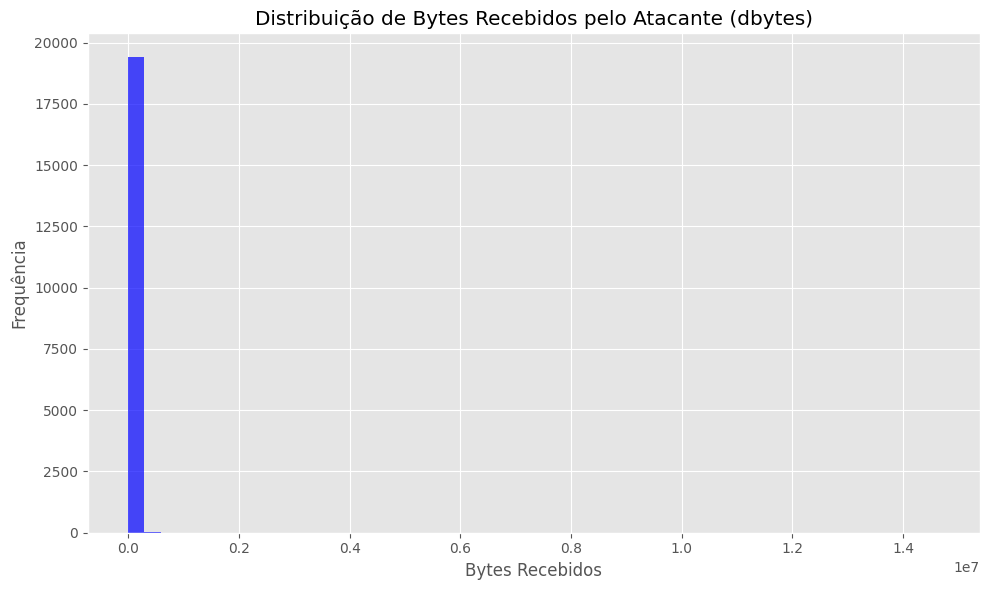

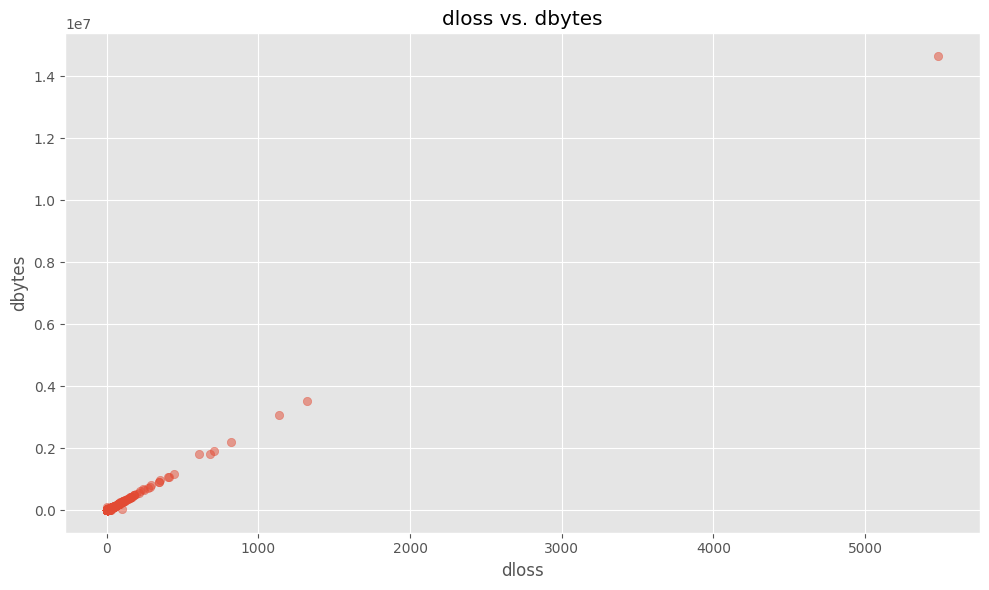

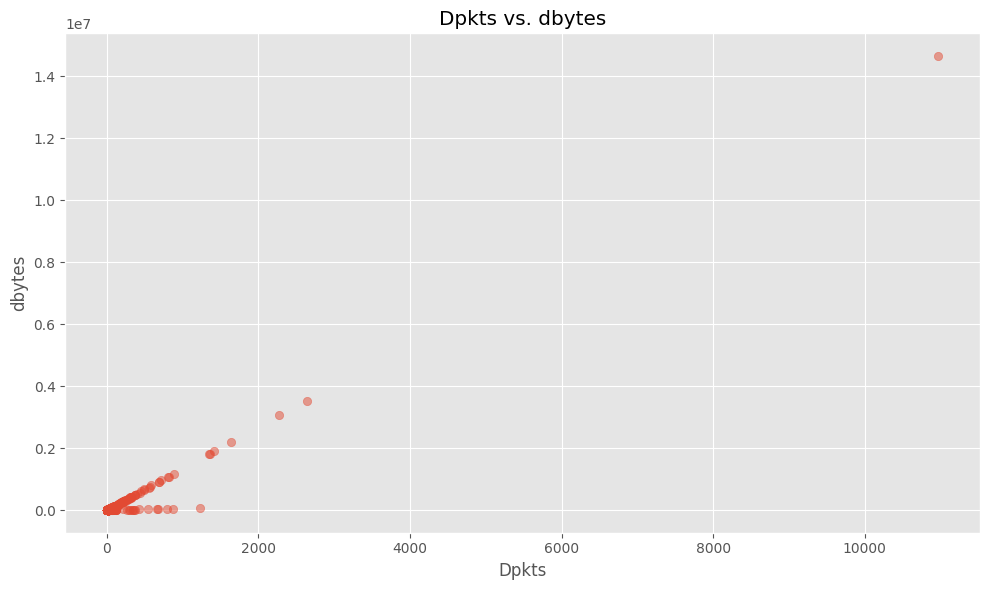

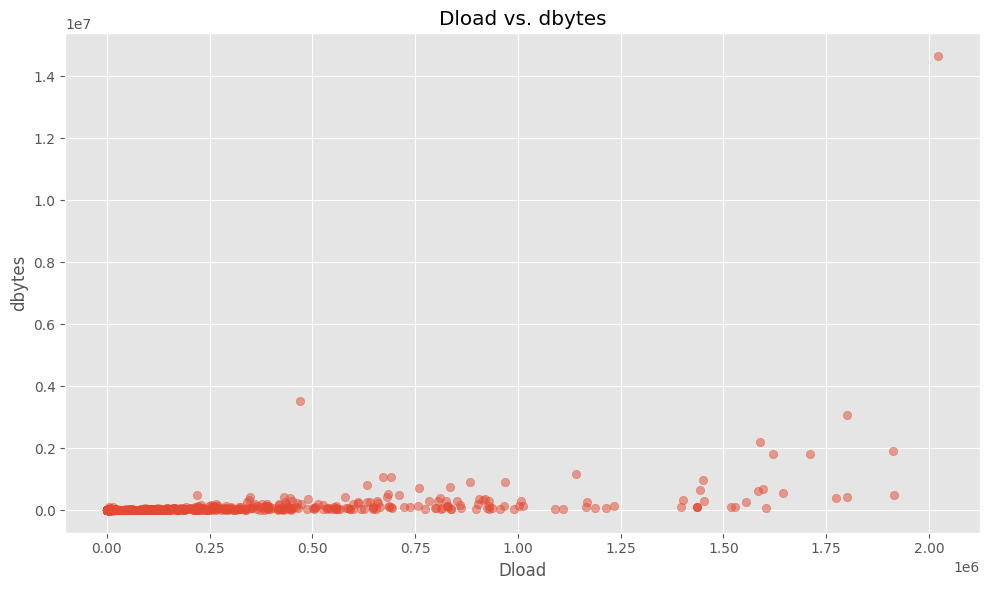

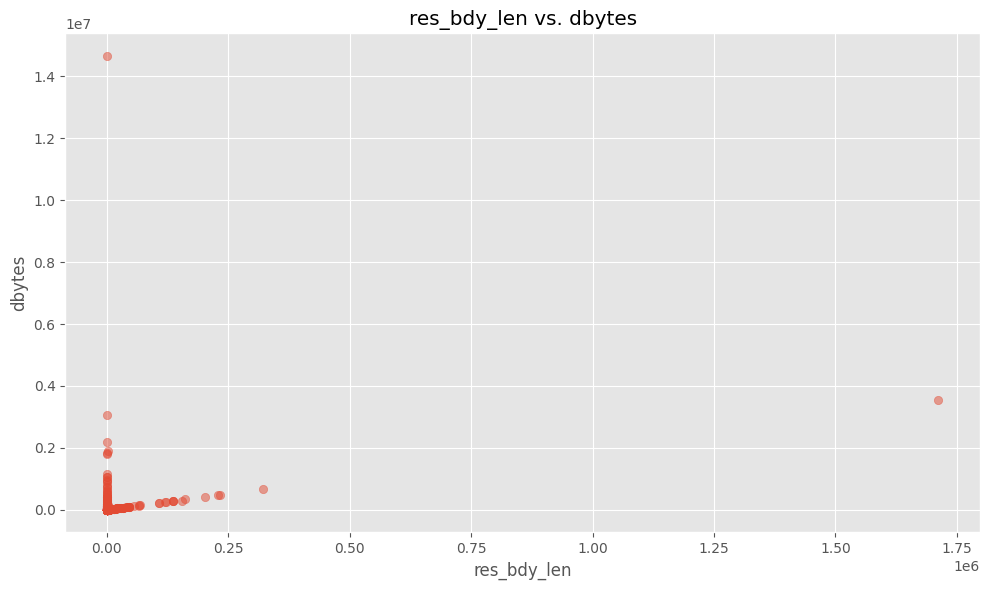

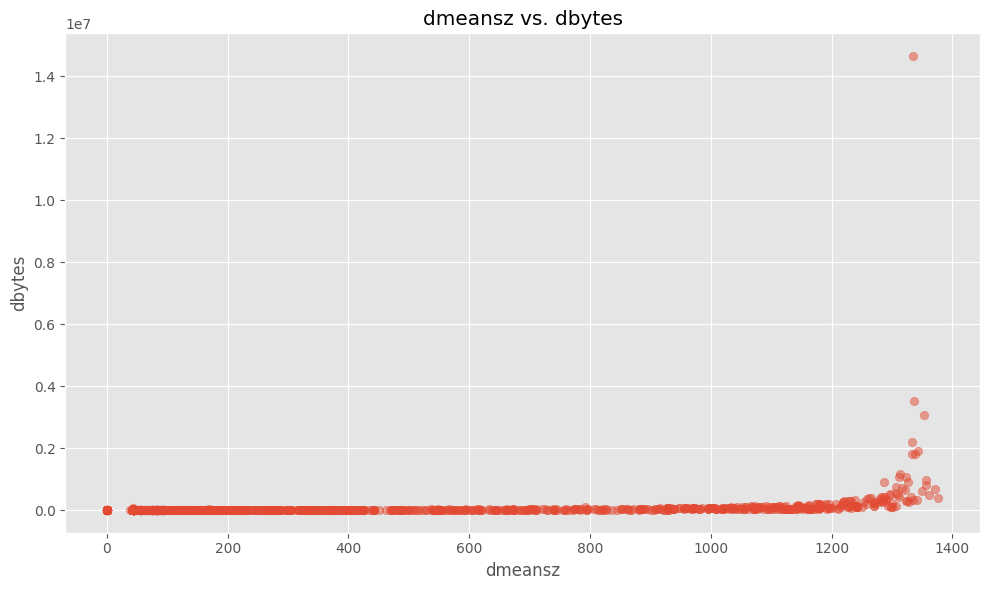

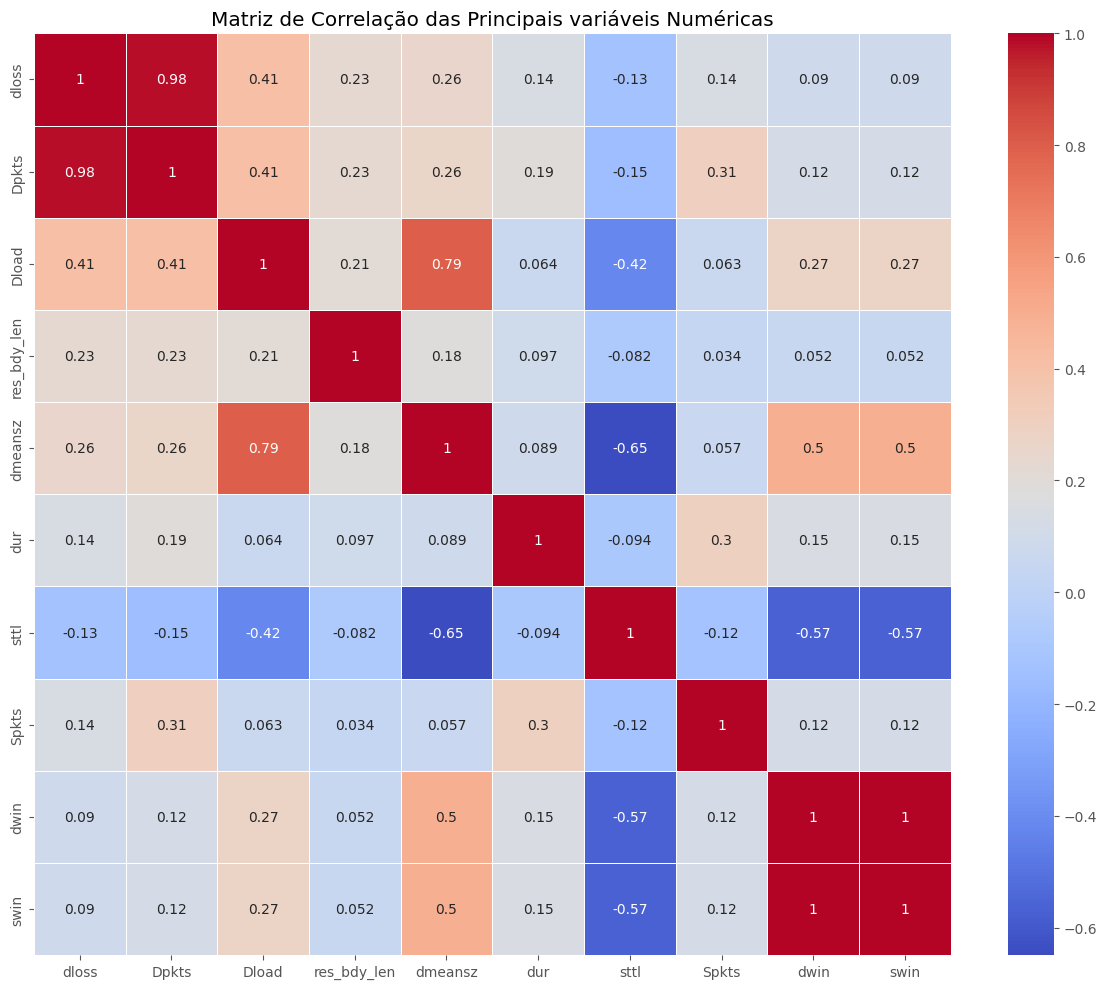

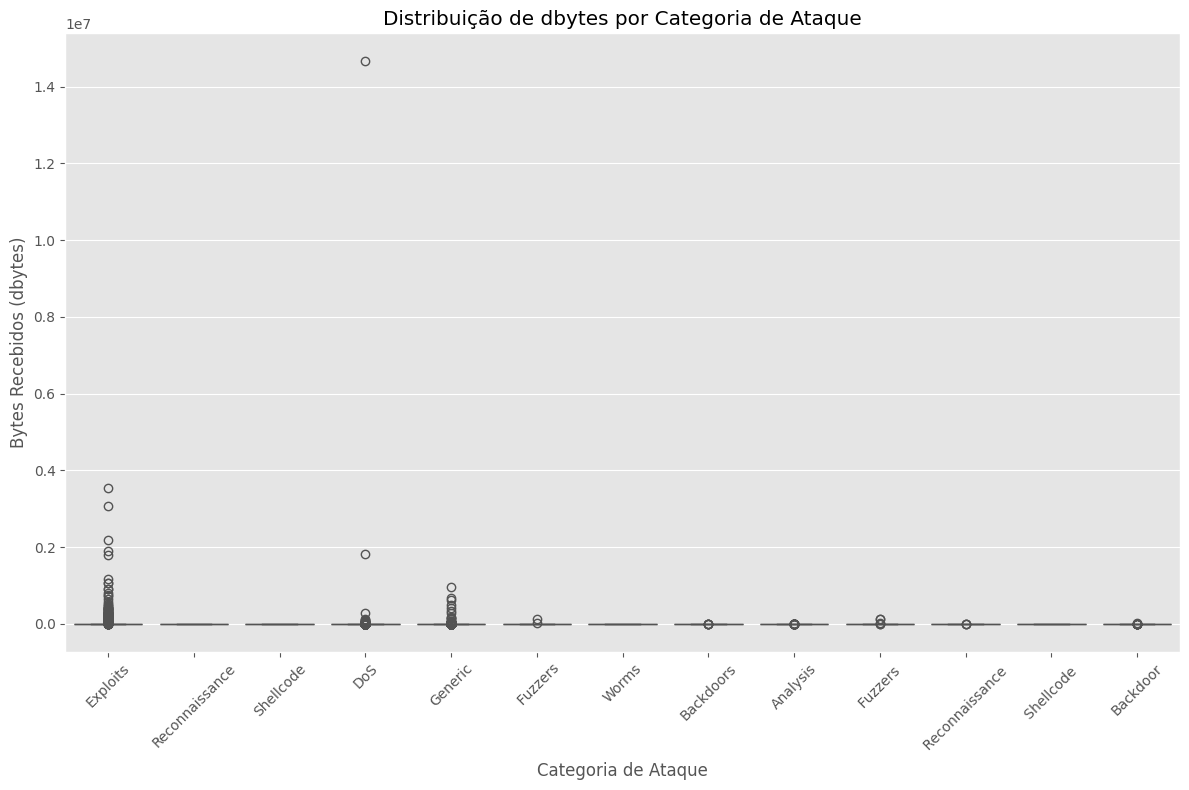

In [13]:
# Para visualização, precisamos converter para Pandas
# Amostrar os dados para não sobrecarregar a memória
sample_df = df_ataques.select("dbytes", *top_numeric_features).sample(fraction=0.1, seed=42).toPandas()

# Configurar o estilo dos gráficos
plt.style.use('ggplot')

# Distribuição da variável alvo
plt.figure(figsize=(10, 6))
plt.hist(sample_df['dbytes'], bins=50, color='blue', alpha=0.7)
plt.title('Distribuição de Bytes Recebidos pelo Atacante (dbytes)')
plt.xlabel('Bytes Recebidos')
plt.ylabel('Frequência')
plt.tight_layout()
plt.savefig('dbytes_distribution.png')
plt.show()

# Gráfico de dispersão das principais variáveis numéricas vs. variável alvo
for i, feature in enumerate(top_numeric_features[:5]):  # Plotando apenas as 5 principais
    plt.figure(figsize=(10, 6))
    plt.scatter(sample_df[feature], sample_df['dbytes'], alpha=0.5)
    plt.title(f'{feature} vs. dbytes')
    plt.xlabel(feature)
    plt.ylabel('dbytes')
    plt.tight_layout()
    plt.savefig(f'{feature}_vs_dbytes.png')
    plt.show()

# Matriz de correlação para as variáveis numéricas
plt.figure(figsize=(12, 10))
correlation_matrix = sample_df[top_numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação das Principais variáveis Numéricas')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

# Boxplot para a variável alvo por categoria de ataque
if 'attack_cat' in df_ataques.columns:
    attack_dbytes = df_ataques.select('attack_cat', 'dbytes').sample(fraction=0.1, seed=42).toPandas()
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='attack_cat', y='dbytes', data=attack_dbytes)
    plt.title('Distribuição de dbytes por Categoria de Ataque')
    plt.xlabel('Categoria de Ataque')
    plt.ylabel('Bytes Recebidos (dbytes)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('dbytes_by_attack_category.png')
    plt.show()

O histograma revela que a maioria das conexões tem um volume de tráfego reduzido, mas que existem alguns valores extremamente altos. Por outro lado, o boxplot foi criado para identificar outliers, permitindo verificar que alguns ataques apresentam volumes de transferência de dados muito superiores à média.
No heatmap de correlação, vemos que dbytes tem uma forte relação com Dpkts e dloss, indicando que conexões mais longas e com maior número de pacotes recebidos tendem a estar associadas a um maior volume de dados transferidos.

### 11. Encerrar a sessão Spark

In [14]:
spark.stop()